# <p style="text-align: center;">AT-TPC Report

 ### <p style="text-align: right;">Authors:
<p style="text-align: right;">Ceulemans Andreas, Fracassetti Stefano, Youssef Ahmed
    

![Active Target](img/AT_drawing.png)

In [1]:
# Common import

import os

import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from helper_functions import *

#Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# <span style="color:darkred">Description of the Project:</span> 


### Task
The main objective is to classify events aquired from an Active Target (simulated data), as being "beam" or "reaction" events. The idea is to implement a "software trigger" which would be able to effectively select only relevant data to save on disk for future analysis.

### Data Format
Data are saved in the file "Mg22_alphaalpha_digiSim.h5", which contains 2000 simulated events: even numbers are "reaction" events, while odd numbers are "beam" event.<br>
Each event is constitued by a point cloud of the active pads for that event.<br>
In turn, every hit pad is associated with a 4-tuple (x,y,z,q): x and y are the position of the hit pad on the detector plane, z is the coordinare associated to the beam axis, and q is the charge deposited on the pad.<br> 
Actually, there is an extra column associated with time (not needed since data already contains the z coordinate thanks to a pre-processing phase), and also an extra column of zeros, unnecessary for this analysis.<br>
The number of hit pads may vary for each event, ranging from around 20, up to a few hundred.

### Strategy
We will apply the ML techiques learned during the Talent Course, in order to analyse the data and reach the best performance possible.<br>
First there will be a section dedicated to data visualization, and in which we will discuss the general characteristic of the task. Afterwards, we will propose various approaches to tackle to problem, and show the results for each methods. Eventually, we will summarize and discuss the outcomes in the final section.

Models used in this project:
- Logistic Regression
- Random Forest
- Dense Neural Networks DNN
- K-Means

# <span style="color:darkred">Data Exploration:</span> 

### Let's have a look to the data file 

#### <p style="text-align: center;"> HDF5 file Format
First we load the data, which are stored as a hdf5 file, a (Hierarchical Data File) format designed to store and organize large amounts of data. The HDF5 file structure includes only two types of objects:
- Datasets, multidimensional arrays of a homogenous type
- Groups, container structures, that can hold Datasets or other groups

What's important to remember is that when opening a HDF5 in python through the command:
```
hf = f = h5py.File('./path/to/file', 'r')
```
we are creating this file objecct in which now  
**Groups work like Dictionaries, and DataSets work like NumPy arrays**

We can check the datasets/groups contained in the file by typing:
``` 
list(hf.keys())
```

#### <p style="text-align: center;"> Analysing "Mg22_alphaalpha_digiSim.h5"
In our case, there were no groups, but 2000 datasets each one corresponding to an event,  
each one with name *.  
Each event(key) is a 2D-array containing a 6 columns, and a variable number of rows (hit pads).


- We first want to visualise the lenght of the data. How many events are we dealing with?<br>
```
len(list(hf.keys()))
```
Here we can se that the there are 2000 events.
<br/><br/>
    
- It is interesting to print a few events type to see how many pads were written per event.<br>
```
list(hf.keys())
hf["Event_[i]"]
```   
We can see now that the keys have the name "Event_[#]", we can see the shape of the event.
It is possible to notice that the beam event have consistently more hit pads in respect to the reaction events.
<br/><br/>
- Eventually we will plot the entire set of information for an event to see the actual structre.<br>
```
hf["Event_[0]"].dtype
hf["Event_[0]"][:]    
```
Here we can see the actual DataSet for an event, and their respective fields and formats.

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# Lenght (number of events):  hf.keys()
print('>>> The number of event(keys) in the file is '  + str(len(hf.keys())) + "\n")

# Printing the single event info
print('  > The first 3 events "Reaction" type:')
for i in ([0,2,4]):
    print('    Event' + str(i) + ':' , hf["Event_[" + str(i) + "]"])
print("\n")

print('  > The first 3 events "Beam" type:')
for i in ([1,3,5]):
    print('    Event' + str(i) + ':' , hf["Event_[" + str(i) + "]"])
print("\n")

# Printing a full DataSet (event)
print(">>> Printing the first event DataSet \n")
print(hf["Event_[0]"].dtype, '\n') # Columns Labels and Formats
print(hf["Event_[0]"][:]) # First Event DataSet



>>> The number of event(keys) in the file is 2000

  > The first 3 events "Reaction" type:
    Event0: <HDF5 dataset "Event_[0]": shape (24,), type "|V48">
    Event2: <HDF5 dataset "Event_[2]": shape (24,), type "|V48">
    Event4: <HDF5 dataset "Event_[4]": shape (24,), type "|V48">


  > The first 3 events "Beam" type:
    Event1: <HDF5 dataset "Event_[1]": shape (195,), type "|V48">
    Event3: <HDF5 dataset "Event_[3]": shape (124,), type "|V48">
    Event5: <HDF5 dataset "Event_[5]": shape (269,), type "|V48">


>>> Printing the first event DataSet 

{'names':['x','y','z','t','A','trackID'], 'formats':['<f8','<f8','<f8','<i4','<f8','<i4'], 'offsets':[0,8,16,24,32,40], 'itemsize':48} 

[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.1368678

### Storing the data

#### <p style="text-align: center;"> (Python) Nested List
This seems to be the most suited structure to handle these data, where every element of the list is an event DataSet. It is handy since avery data set have different lenght, and list are able to handle this without problem.
In the next cell, we import the data in a list.
We can show each element of a list, which correspond to a single event of the hdf5 file, checking that is the same as the hdf5 file.
    
#### <p style="text-align: center;"> (Pandas) DataFrame and Series, (Numpy) Array ?
These structure do not seem to respond nicely to our needs. 
    
- *(Pandas) DataFrame* are 2D structure of fixed lenght. In our case, we would need 3D array, where one variable has a variable lenght. Providing that we could stored "fake values" where data is missing, there is still the proble we can not store all the DataSet in a DataFrame structure type. However it is possible to store each event in a single and different DataFrace structure, or in a list of DataFrame type (not sure this is possible). There is no advantage to do this in respect to a list in the end, so we still opt on nested list.<br/><br/>
- *(Pandas) Series* are 1D arrays capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index. Not adapted for our data.<br/><br/>   
- *(Numpy) Array* are a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension. This structure is not adapt to host our data, since we need again a fixed dimension. In principle it would be possible, leaving NaN where data is missing. This method is inefficient. As for DataFrame, it would be possible to use this struture to store each event in a single and different Numpy Array
    

In [3]:
# Importing the data in a python list: AllDataList 
AllDataList = []
for i in range(len(hf.keys())):
    KeyString = "Event_[" + str(i) +"]"
    AllDataList.append(hf[KeyString][:]) # each list element is an event 2d matrix

# Printing a full DataSet (event)
print(">>> Printing the first event DataSet: \n")
print(AllDataList[0], '\n') # same as print(hf["Event_[0]"][:])
print(">>> Printing the first row of the first event:")
print(AllDataList[0][0], '\n')
print(">>> Printing the first feature (x) of the first row of Event_[0]:")
print(AllDataList[0][0][0], '\n')
    

>>> Printing the first event DataSet: 

[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.13686783e+04, 0)
 ( 2.45413303e+00,  1.45075214, 962., 481, 3.21076480e+03, 0)
 ( 4.90825081e+00, -5.70140886, 964., 482, 4.45706507e+01, 0)
 ( 2.45410442e+00,  7.05056143, 966., 483, 2.11128009e+01, 0)
 (-2.45413113e+00, -7.05056143, 984., 492, 1.90553867e+01, 0)
 (-4.90824747e+00,  5.70140886, 986., 493, 1.97473273e+01, 0)
 ( 4.90825081e+00,  5.70140886, 986., 493, 2.12675051e+01, 0)
 (-4.90824747e+00,  2.79990482, 990., 495, 4.76823698e+01, 0)
 (-4.90824747e+00, -5.70140886, 990., 495, 2.12226325e+01, 0)
 (-4.90824747e+00, -2.79990482, 990., 495, 2.63826991e+02, 0)
 ( 4.90825081e+00,  2.79990482, 990., 495, 4.01348998e+02, 0)
 (-2.45413113e+00,  7.05056143

### Labeling and cleaning

#### <p style="text-align: center;"> Labeling

The last step before deal with ML algorithm is to label and clean the data.
We know from the task description that the data come labeled:
- Reacion Event (label=1)
- Beam Event (label=0)  
    
Note that assigning 1 or 0 is a matter of choice, it is possible to do the opposite.
This choice reflect the idea that a reaction event is to keep, while a beam event must be rejected, so associated to a nul value.

#### <p style="text-align: center;"> Cleaning
   
This phase is rather simple, the events do no contain missing values. We only noticed that we deal with "empty" events. Event number (384, 430,484,914,1204 (numbers correspond to keys)) do not contain any value, so must be discarded.  
The DataSet we are going to analyse is formed by 1995 non-empty events.

In [4]:
# List of labels 
LabelsList = []
# Selecting Empty Events 
EmptyDataList = []

# List of not empty Events
DataList = []

for i in range(len(AllDataList)):
    if (len(AllDataList[i])>0): # Choosing only not empy events
        DataList.append(AllDataList[i])     
        if (i%2==0): # Reaction Event (even) --> label = 1
            LabelsList.append(1)
        else:        # Beam Event (odd)     --> label = 0
            LabelsList.append(0)
    else:
        EmptyDataList.append(i)

# Converting List in a Numpy Array: it is faster and easier to handle.
Labels = np.array(LabelsList)

print("Dataset contains " + str(len(DataList)) + " non-empty events")
print("Data contains %i empty events, of indexes:"  % len(EmptyDataList),  EmptyDataList)

Dataset contains 1995 non-empty events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]


All these operations: importing the data, labelling and cleaning have been implemented all together in the function called "load_data", stored in the file: "helper_funvtions.py". This would granted more readability of our code.
<br/><br/>So that, the code would look rather like this:
```
DataList, Labels = load_data(hf)
```

### Slpitting the data

#### <p style="text-align: center;"> The perfect combination: Training - Validation - Testing
In every ML algorithm we have to first split the data in training, validation and (possibly) test. 
- *Training Data* will be used to feed the algorithm and to train it. 
- *Validation Data* are going to be used in order to see how our algorithm performs on data which has not be used to tune it. But anyway, validation data would be useful to tune our algorithm, deciding when to stop to train it, and adjust some parameters.
- *Test Data* are meant to test the algorithm on completely newly data, such as they were a different dataset.
    
Usually the original data are divided for 90% - 70% into training and the rest for validation and testing.
    
Sklearn provides a function: "train_test_split" which makes this operation very handy. This function would split the data in two subsets, in a fraction which is possible to specify through the function options. Applying twice this function we can reach our goal. 
    
In order to save memory and computation time (because we care about computers), we do not load the function with actually features and labels, as more obvious choice, but simply with a list of index, which would result in the creation of indexes subsets, wich can be used to separate the data. 
The outcome of this operation can be viewed as shuffling the indexes in three subsets, of desider lenght.
       

In [14]:
# Create an ordered index list : [0,1,2,...,len(DataList)]
x_idx = np.arange(len(DataList))

# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)

# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was divided into:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was divided into:
1615 training events,
180  validation events, and
200  test events


# <span style="color:darkred">Extracting Features:</span> 

#### <p style="text-align: center;"> Selecting only relevant characteristics
    
Which data do we feed into the algorithm? We cannot feed all the 2D martix containing all the information for each event, we need to see a design matrix, and select relevant features for each events. Furthermore, a non-fixed lenght of the 2D matrix would create additonal challenges in how to manage those data.

So, we need to extract a number of relevant features for each event, based on the information available for that event. Whtich characteristcs would help us differentiating events based on the fact that we are dealing with a "beam" rather than a "reaction" label? 

The question can be answered having a look to different events, previously we noticed e.g. that the beam events tend to have a much larger number of hit pads respect to reation events. Other features are not obvious, and need a bit of analysis.
    
Let's get some insights of the features we can use! And to do this let's first have a look to the events, plotting in a 3D graph. We do this using the function "plot_3d_event", previously defined in the other file.
    


### Visualizing the data: let's get some insight!
Plotting some events, using seaborn. Only fancy plots allowed.

Reaction Events


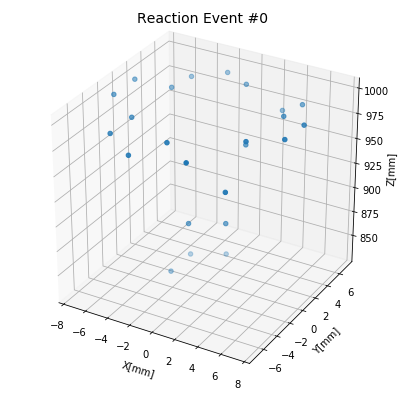

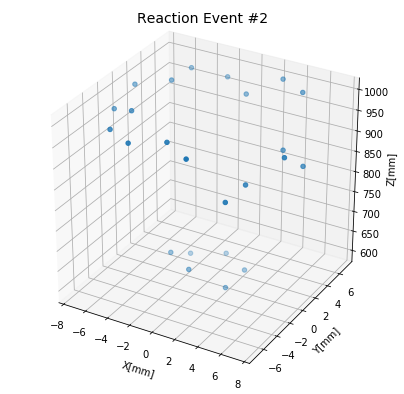

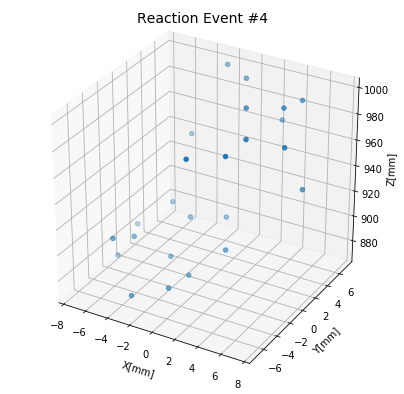

In [12]:
# 3D plot of some Reaction events
print("Reaction Events")
for i in [0,2,4]:
    plot_3d_event(DataList,Labels,i)

Beam Events


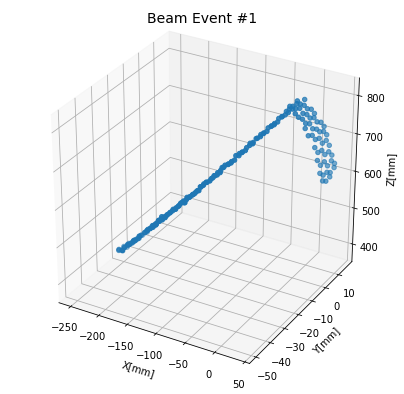

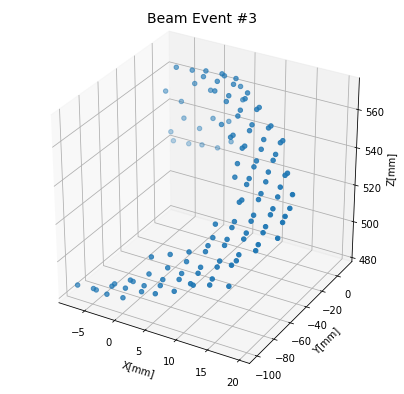

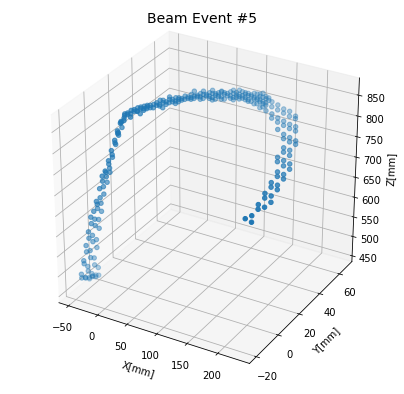

In [13]:
print("Beam Events")    
# 3D plot of some Beam events
for i in [1,3,5]:
    plot_3d_event(DataList,Labels,i)

###  Selecting Features
After plotting the data (two previous cells), it is quite clear that the number of pads plays a crucial role, but not only that. By eyes we can somehow differentiatig the events to be labelled as "beam" since they present a more definite (and almost straight?) track.
We thought some relevant characteristics could be the average value of x,y and z, or rather a weighted avereage, based on the charge deposited. Also, the total deposited charge can be an interesting quantity. 

Here a list of the quantity we calculated:
```
# Every quantity refers to each single event

MeanXPerEvent         # Max X value 
MeanYPerEvent         # Max Y value 
MeanZPerEvent         # Max Z value
SumAPerEvent          # Total deposited charge
PadsPerEvent          # Number of hit pads
MeanWeightedXPerEvent # Charge weighted X 
MeanWeightedYPerEvent # Charge weighted Y
StDevXPerEvent        # std X 
StDevYPerEvent        # std Y
StDevZPerEvent        # std Z
FracClosePtsPerEvent  # number of pads inside a region of radius 10cm
```


In [16]:
MeanXPerEvent = np.zeros(len(DataList))
MeanYPerEvent = np.zeros(len(DataList))
MeanZPerEvent = np.zeros(len(DataList))
SumAPerEvent = np.zeros(len(DataList))
PadsPerEvent = np.zeros(len(DataList))
MeanWeightedXPerEvent = np.zeros(len(DataList))
MeanWeightedYPerEvent = np.zeros(len(DataList))
StDevXPerEvent = np.zeros(len(DataList))
StDevYPerEvent = np.zeros(len(DataList))
StDevZPerEvent = np.zeros(len(DataList))
FracClosePtsPerEvent = np.zeros(len(DataList)) # fraction of points satisfying x^2+y^2<100 in event



for i in range(len(DataList)):

    for j in range(len(DataList[i])):
        MeanXPerEvent[i] = MeanXPerEvent[i] + DataList[i][j][0]
        MeanYPerEvent[i] = MeanYPerEvent[i] + DataList[i][j][1]
        MeanZPerEvent[i] = MeanZPerEvent[i] + DataList[i][j][2]
        SumAPerEvent[i] = SumAPerEvent[i] + DataList[i][j][4]
        MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i] + DataList[i][j][0]*DataList[i][j][4]
        MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i] + DataList[i][j][1]*DataList[i][j][4]
        if (DataList[i][j][0]**2 + DataList[i][j][1]**2 < 100):
            FracClosePtsPerEvent[i] = FracClosePtsPerEvent[i] + 1 
        
    
    MeanXPerEvent[i] = MeanXPerEvent[i]/len(DataList[i])
    MeanYPerEvent[i] = MeanYPerEvent[i]/len(DataList[i])
    MeanZPerEvent[i] = MeanZPerEvent[i]/len(DataList[i])
    MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i]/len(DataList[i])
    MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i]/len(DataList[i])
    FracClosePtsPerEvent[i] = FracClosePtsPerEvent[i]/len(DataList[i])
    
    #second for loop for calculation of standard deviation
    for j in range(len(DataList[i])):
        StDevXPerEvent[i] = StDevXPerEvent[i] + (DataList[i][j][0]-MeanXPerEvent[i])**2
        StDevYPerEvent[i] = StDevYPerEvent[i] + (DataList[i][j][1]-MeanYPerEvent[i])**2
        StDevZPerEvent[i] = StDevZPerEvent[i] + (DataList[i][j][2]-MeanZPerEvent[i])**2
   
    StDevXPerEvent[i] = np.sqrt(StDevXPerEvent[i])/(len(DataList[i])-1)
    StDevYPerEvent[i] = np.sqrt(StDevYPerEvent[i])/(len(DataList[i])-1)
    StDevZPerEvent[i] = np.sqrt(StDevZPerEvent[i])/(len(DataList[i])-1)
    
    PadsPerEvent[i] = len(DataList[i])
    


### Visualizing some features 

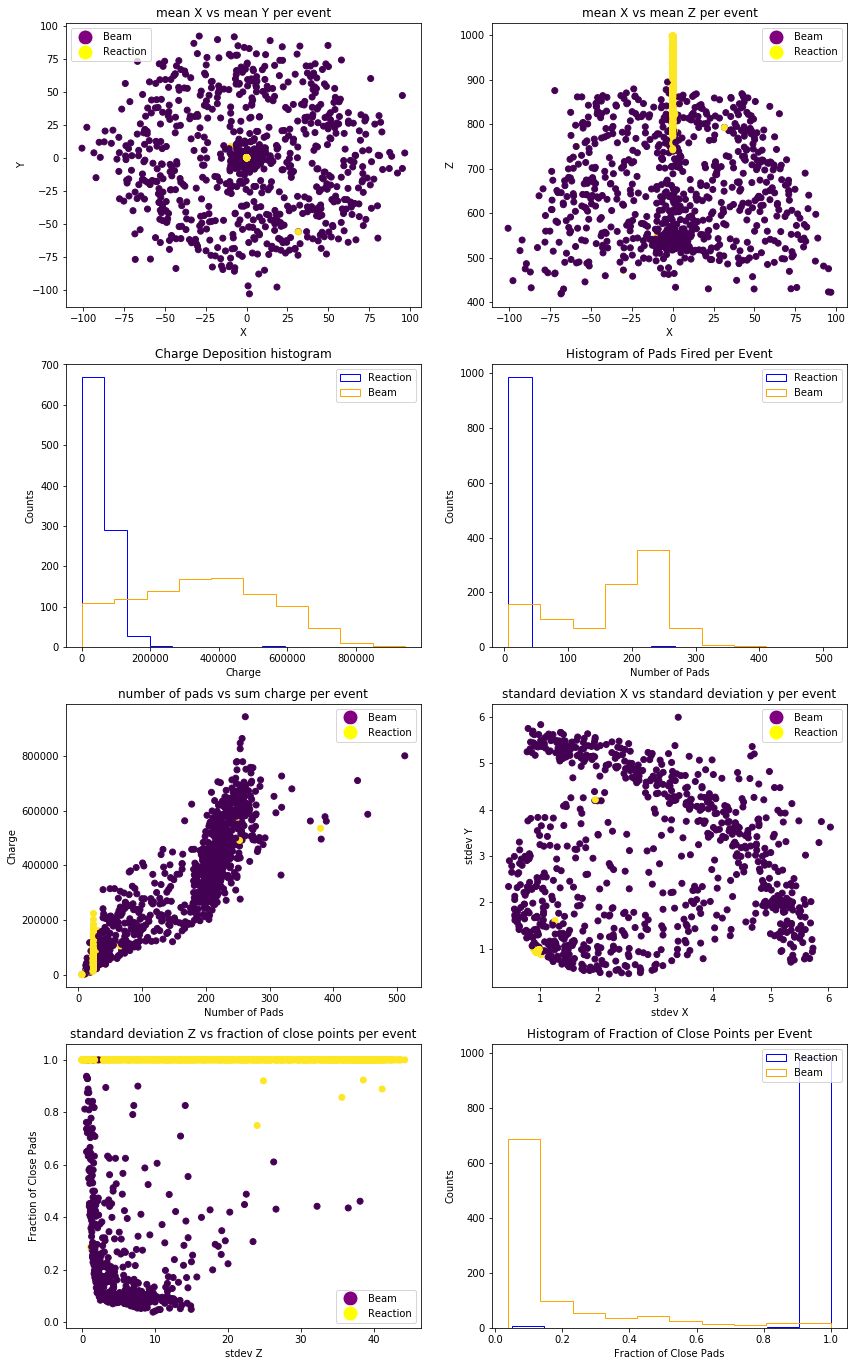

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(14, 24))

#define legend for 2d plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor='purple', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor='yellow', markersize=15)]

ax[0][0].scatter(MeanXPerEvent[train_idx],MeanYPerEvent[train_idx], c = Labels[train_idx])
ax[0][0].set_title("mean X vs mean Y per event")
ax[0][0].set_xlabel("X")
ax[0][0].set_ylabel("Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_idx],MeanZPerEvent[train_idx], c = Labels[train_idx])
ax[0][1].set_title("mean X vs mean Z per event")
ax[0][1].set_xlabel("X")
ax[0][1].set_ylabel("Z")
ax[0][1].legend(handles=legend_elements)

ax[1][0].hist(SumAPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[1][0].hist(SumAPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[1][0].set_title("Charge Deposition histogram")
ax[1][0].set_xlabel("Charge")
ax[1][0].set_ylabel("Counts")
ax[1][0].legend()

ax[1][1].hist(PadsPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[1][1].hist(PadsPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[1][1].set_title("Histogram of Pads Fired per Event")
ax[1][1].set_xlabel("Number of Pads")
ax[1][1].set_ylabel("Counts")
ax[1][1].legend()

ax[2][0].scatter(PadsPerEvent[train_idx],SumAPerEvent[train_idx], c = Labels[train_idx])
ax[2][0].set_title("number of pads vs sum charge per event")
ax[2][0].set_xlabel("Number of Pads")
ax[2][0].set_ylabel("Charge")
ax[2][0].legend(handles=legend_elements)

ax[2][1].scatter(StDevXPerEvent[train_idx],StDevYPerEvent[train_idx], c = Labels[train_idx])
ax[2][1].set_title("standard deviation X vs standard deviation y per event")
ax[2][1].set_xlabel("stdev X")
ax[2][1].set_ylabel("stdev Y")
ax[2][1].legend(handles=legend_elements)

ax[3][0].scatter(StDevZPerEvent[train_idx],FracClosePtsPerEvent[train_idx], c = Labels[train_idx])
ax[3][0].set_title("standard deviation Z vs fraction of close points per event")
ax[3][0].set_xlabel("stdev Z")
ax[3][0].set_ylabel("Fraction of Close Pads")
ax[3][0].legend(handles=legend_elements)

ax[3][1].hist(FracClosePtsPerEvent[Labels>0.5], color='blue', label = 'Reaction', histtype = 'step')
ax[3][1].hist(FracClosePtsPerEvent[Labels<0.5], color='orange', label = 'Beam', histtype = 'step')
ax[3][1].set_title("Histogram of Fraction of Close Points per Event")
ax[3][1].set_xlabel("Fraction of Close Pads")
ax[3][1].set_ylabel("Counts")
ax[3][1].legend()

# Machine Learning

# Conclusions